In [2]:
# Pull data command:
# python download_data.py --project=model-free-minigrid --history_vars step reward recon_loss ep_length --params env_name ae_model_type ep_length mf_steps rl_start_step n_ae_updates ae_recon_loss e2e_loss

In [3]:
import os
import sys
sys.path.append(os.path.abspath('../../..')) 
from plotting_utils import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns

%matplotlib inline
set_matplotlib_style()

In [4]:
data_path = 'data/model-free-minigrid_data.csv'
df = pd.read_csv(data_path, index_col=0)
df['Model Type'] = df['ae_model_type']
df

,step,ep_length,ep_reward,reward,ae_model_type,ae_recon_loss,codebook_size,env_name,filter_size,rl_start_step,experiment_key,count,beta,Model Type
0,10000,940.400000,0.073640,0.000074,ae,True,NaN,minigrid-door-key-stochastic,8,500000,b4826bc0c0494092a4aa8bd2f7d93a9c,NaN,NaN,ae
1,20000,834.333333,0.190767,0.000229,ae,True,NaN,minigrid-door-key-stochastic,8,500000,b4826bc0c0494092a4aa8bd2f7d93a9c,NaN,NaN,ae
2,30000,949.636364,0.072600,0.000080,ae,True,NaN,minigrid-door-key-stochastic,8,500000,b4826bc0c0494092a4aa8bd2f7d93a9c,NaN,NaN,ae
3,40000,1000.000000,0.000000,0.000000,ae,True,NaN,minigrid-door-key-stochastic,8,500000,b4826bc0c0494092a4aa8bd2f7d93a9c,NaN,NaN,ae
4,50000,934.800000,0.078680,0.000079,ae,True,NaN,minigrid-door-key-stochastic,8,500000,b4826bc0c0494092a4aa8bd2f7d93a9c,NaN,NaN,ae
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15852,850000,35.627240,1.054715,0.029441,vqvae,True,256.0,minigrid-door-key-stochastic,6,500000,a5595932b9914bacb855aa98e614995a,True,0.01,vqvae
15853,860000,41.217213,1.051983,0.025655,vqvae,True,256.0,minigrid-door-key-stochastic,6,500000,a5595932b9914bacb855aa98e614995a,True,0.01,vqvae
15854,870000,33.936620,1.033685,0.029462,vqvae,True,256.0,minigrid-door-key-stochastic,6,500000,a5595932b9914bacb855aa98e614995a,True,0.01,vqvae
15855,880000,35.334471,1.036010,0.030250,vqvae,True,256.0,minigrid-door-key-stochastic,6,500000,a5595932b9914bacb855aa98e614995a,True,0.01,vqvae


In [5]:
data_path = 'data/model-free-minigrid_data.csv'
df = pd.read_csv(data_path, index_col=0)
df['Model Type'] = df['ae_model_type']

model_type_map = {
  'ae': 'Continuous',
  'vqvae': 'Discrete',
  'fta_ae': 'FTA',
  'softmax_ae': 'Softmax AE',
}
df['Model Type'] = df['Model Type'].apply(lambda x: model_type_map[x])
df['Model Type'] = df.apply(
  (lambda x: x['Model Type'] if x['ae_recon_loss'] else 'End-to-End'), axis=1)

# Remove all softmax
df = df[df['ae_model_type'] != 'softmax_ae']

df['return'] = df['reward'] * df['ep_length']

# Drop na in rows where ae_recon_loss is True
# df = df.dropna(subset=['ae_recon_loss'])

## Baseline RL performance

In [6]:
determ_env_df = df[
  ~df['env_name'].str.contains('-rand') &
  (df['rl_start_step'] == 0) &
  ((df['Model Type'] == 'Continuous') | (df['Model Type'] == 'Discrete'))
]

set_matplotlib_style(style='4-row')

for env_name, group in determ_env_df.groupby(['env_name']):
  max_step = group['step'].max()
  # Print number of unique experiment_key values per Model Type
  print(group.groupby(['Model Type'])['experiment_key'].nunique())
  env_name = env_name[0]
  if 'crossing' in env_name.lower():
    max_step = int(6e5)
  elif 'key' in env_name.lower():
    max_step = int(1e6)

  
  color_palette = get_color_palette(group['Model Type'].unique())
  sns.lineplot(
    group, x='step', y='ep_length', hue='Model Type',
    errorbar=t_distrib, palette=color_palette)
  
  plt.title(f'{standardize_env_name(env_name)}')
  set_fig_labels('Time Steps', 'Episode Length', xsci=True)

  yticks = plt.gca().get_yticks()
  plt.gca().set_yticks(yticks[1::2])

  xticks = plt.gca().get_xticks()
  # plt.gca().set_xticks(xticks[1::2])

  plt.xlim(0, max_step)

  max_y = group['ep_length'].max()
  max_y = int(np.ceil(max_y / 100)) * 100
  plt.ylim(0, max_y)
  plt.gca().set_yticks([0, max_y // 2, max_y])
  
  save_fig_versions(f'{standardize_env_name(env_name)}_vanilla_rl_ep_len')
  plt.show()

In [7]:
determ_env_df = df[
  ~df['env_name'].str.contains('-rand') &
  (df['rl_start_step'] == 0)
]

set_matplotlib_style(style='4-row')

for env_name, group in determ_env_df.groupby(['env_name']):
  max_step = group['step'].max()
  # Print number of unique experiment_key values per Model Type
  print(group.groupby(['Model Type'])['experiment_key'].nunique())
  env_name = env_name[0]
  if 'crossing' in env_name.lower():
    max_step = int(6e5)
  elif 'key' in env_name.lower():
    max_step = int(1e6)

  
  color_palette = get_color_palette(group['Model Type'].unique())
  sns.lineplot(
    group, x='step', y='ep_length', hue='Model Type',
    errorbar=t_distrib, palette=color_palette)
  
  plt.title(f'{standardize_env_name(env_name)}')
  set_fig_labels('Time Steps', 'Episode Length', xsci=True)

  yticks = plt.gca().get_yticks()
  plt.gca().set_yticks(yticks[1::2])

  xticks = plt.gca().get_xticks()
  # plt.gca().set_xticks(xticks[1::2])

  plt.xlim(0, max_step)
  
  max_y = group['ep_length'].max()
  max_y = int(np.ceil(max_y / 100)) * 100
  plt.ylim(0, max_y)
  plt.gca().set_yticks([0, max_y // 2, max_y])
  
  save_fig_versions(f'{standardize_env_name(env_name)}_vanilla_rl_ep_len_baselines')
  plt.show()

### Recon loss

In [8]:
determ_env_df = df[
  ~df['env_name'].str.contains('-rand') &
  (df['rl_start_step'] == 0) &
  df['ae_recon_loss'] &
  ((df['Model Type'] == 'Continuous') | (df['Model Type'] == 'Discrete'))
]

set_matplotlib_style()

for env_name, group in determ_env_df.groupby(['env_name']):
  group = bin_df(group, 100).dropna()
  max_step = np.percentile(group['step'], 25.8)
  group = group[group['step'] <= max_step]
  
  print(group.groupby(['Model Type'])['experiment_key'].nunique())
  
  # Set up the figure and axis
  fig, ax = plt.subplots()

  # Create a list of unique Model Types
  model_types = group['Model Type'].unique()
  color_palette = get_color_palette(group['Model Type'].unique())

  all_runs = {}

  # Loop through the model types
  for i, model_type in enumerate(model_types):
    # Filter the data for the current model type
    filtered_data = group[group['Model Type'] == model_type]
    # Loop through the individual experiments within the current model type
    for experiment_key, experiment_data in filtered_data.groupby('experiment_key'):
      all_runs[experiment_key] = {
        'data': experiment_data,
        'color': color_palette[model_type]
        }

  # Loop through the individual experiments in random order
  rand_keys = list(all_runs.keys())
  np.random.shuffle(rand_keys)

  for experiment_key in rand_keys:
    # Plot the line with partial transparency
    sns.lineplot(
      data=all_runs[experiment_key]['data'],
      x='step',
      y='recon_loss',
      ax=ax,
      color=all_runs[experiment_key]['color'],
      alpha=0.3,
      legend=False,
    )

  # Add a legend manually
  for i, model_type in enumerate(model_types):
    ax.plot([], [], color=color_palette[model_type], label=model_type)

  ax.legend(title='Model Type')
  
  plt.title(f'{standardize_env_name(env_name)} Encoder Performance')
  set_fig_labels('Time Steps', 'Reconstruction MSE Loss', xsci=True)

  plt.xlim(0, max_step)
  plt.ylim(0, np.percentile(group['recon_loss'], 90))

  save_fig_versions(f'{standardize_env_name(env_name)}_vanilla_rl_recon')
  plt.show()

In [9]:
determ_env_df = df[
  ~df['env_name'].str.contains('-rand') &
  (df['rl_start_step'] == 0) &
  df['ae_recon_loss']
]

set_matplotlib_style()

for env_name, group in determ_env_df.groupby(['env_name']):
  group = bin_df(group, 100).dropna()
  max_step = np.percentile(group['step'], 25.8)
  group = group[group['step'] <= max_step]
  
  print(group.groupby(['Model Type'])['experiment_key'].nunique())
  
  # Set up the figure and axis
  fig, ax = plt.subplots()

  # Create a list of unique Model Types
  model_types = group['Model Type'].unique()
  color_palette = get_color_palette(group['Model Type'].unique())

  all_runs = {}

  # Loop through the model types
  for i, model_type in enumerate(model_types):
    # Filter the data for the current model type
    filtered_data = group[group['Model Type'] == model_type]
    # Loop through the individual experiments within the current model type
    for experiment_key, experiment_data in filtered_data.groupby('experiment_key'):
      all_runs[experiment_key] = {
        'data': experiment_data,
        'color': color_palette[model_type]
        }

  # Loop through the individual experiments in random order
  rand_keys = list(all_runs.keys())
  np.random.shuffle(rand_keys)

  for experiment_key in rand_keys:
    # Plot the line with partial transparency
    sns.lineplot(
      data=all_runs[experiment_key]['data'],
      x='step',
      y='recon_loss',
      ax=ax,
      color=all_runs[experiment_key]['color'],
      alpha=0.3,
      legend=False,
    )

  # Add a legend manually
  for i, model_type in enumerate(model_types):
    ax.plot([], [], color=color_palette[model_type], label=model_type)

  ax.legend(title='Model Type')
  
  plt.title(f'{standardize_env_name(env_name)} Encoder Performance')
  set_fig_labels('Time Steps', 'Reconstruction MSE Loss', xsci=True)

  plt.xlim(0, max_step)
  plt.ylim(0, np.percentile(group['recon_loss'], 90))

  save_fig_versions(f'{standardize_env_name(env_name)}_vanilla_rl_recon_baselines')
  plt.show()

## Delayed start RL performance

Model Type
Continuous      1
Discrete      170
Name: experiment_key, dtype: int64
$\times\mathdefault{10^{6}}\mathdefault{}$


FileNotFoundError: [Errno 2] No such file or directory: '../figures/svg/Minigrid Door Key_delayed_rl_ep_len_nl.svg'

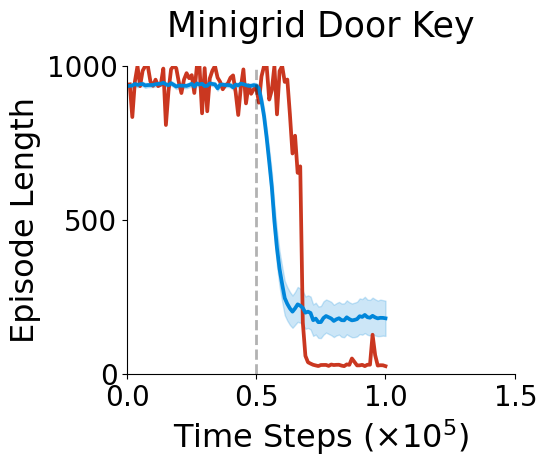

In [10]:

determ_env_df = df[
  ~df['env_name'].str.contains('-rand') &
  (
    (
      (df['rl_start_step'] > 100000) &
      
      df['ae_recon_loss']
    ) |
    ~df['ae_recon_loss']
  ) &
  ((df['Model Type'] == 'Continuous') | (df['Model Type'] == 'Discrete'))
]

set_matplotlib_style(style='4-row')


for env_name, group in determ_env_df.groupby(['env_name']):
  env_name = env_name[0]
  
  max_step = group['step'].max()
  if 'crossing' in env_name.lower():
    max_step = int(8e5)
  elif 'key' in env_name.lower():
    max_step = int(1.5e6)
  rl_start_step = group.iloc[0]['rl_start_step']

  print(group.groupby(['Model Type'])['experiment_key'].nunique())
  
  color_palette = get_color_palette(group['Model Type'].unique())
  sns.lineplot(
    group, x='step', y='ep_length', hue='Model Type',
    errorbar=t_distrib, palette=color_palette)
  
  plt.axvline(x=rl_start_step, color='black', linestyle='--', alpha=0.3, linewidth=2)
  
  plt.title(f'{standardize_env_name(env_name)}')
  set_fig_labels('Time Steps', 'Episode Length', xsci=True)

  plt.xlim(0, max_step)

  max_y = group['ep_length'].max()
  max_y = int(np.ceil(max_y / 100)) * 100
  plt.ylim(0, max_y)
  plt.gca().set_yticks([0, max_y // 2, max_y])
  
  save_fig_versions(f'{standardize_env_name(env_name)}_delayed_rl_ep_len')
  plt.show()

beta
0.000    30
0.001    30
Name: experiment_key, dtype: int64
beta
0.000    30
0.001    30
Name: experiment_key, dtype: int64
$\times\mathdefault{10^{6}}\mathdefault{}$


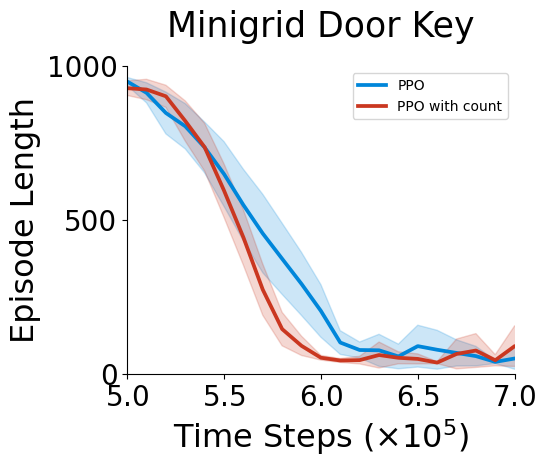

In [26]:
label_map = {0.0: "PPO", 0.001: "PPO with count"}

determ_env_df = df[
  ~df['env_name'].str.contains('-rand') &
  (
    (
      (df['rl_start_step'] > 100000) &
      
      df['ae_recon_loss']
    ) |
    ~df['ae_recon_loss']
  ) &
  ((df['Model Type'] == 'Continuous') | (df['Model Type'] == 'Discrete'))
]
determ_env_df = determ_env_df.dropna()
determ_env_df = determ_env_df[determ_env_df['beta'].isin([0.0, 0.001])]


set_matplotlib_style(style='4-row')
determ_env_df = determ_env_df[determ_env_df['count']]
# determ_env_df = determ_env_df['beta'].isin([0.0, 0.001])


for env_name, group in determ_env_df.groupby(['env_name']):
  env_name = env_name[0]

  group['beta_label'] = group['beta'].map(label_map)
  hue_labels = group['beta'].apply(lambda x: f'beta = {x}')

  
  max_step = group['step'].max()
  if 'crossing' in env_name.lower():
    max_step = int(8e5)
  elif 'key' in env_name.lower():
    max_step = int(7e5)
  rl_start_step = group.iloc[0]['rl_start_step']

  print(group.groupby(['beta'])['experiment_key'].nunique())
  len_classes = len(group.groupby(['beta'])['experiment_key'].nunique())
  print(group.groupby(['beta'])['experiment_key'].nunique())
  color_palette = get_color_palette(n=len_classes)
  sns.lineplot(
    group, x='step', y='ep_length', hue='beta_label',
    errorbar=t_distrib, palette=color_palette)
  
#   plt.axvline(x=rl_start_step, color='black', linestyle='--', alpha=0.3, linewidth=2)
  
  plt.title(f'{standardize_env_name(env_name)}')
  set_fig_labels('Time Steps', 'Episode Length', xsci=True)
  plt.xlim(rl_start_step, max_step)
  
  max_y = group['ep_length'].max()
  max_y = int(np.ceil(max_y / 100)) * 100
  plt.ylim(0, max_y)
  plt.gca().set_yticks([0, max_y // 2, max_y])
  plt.legend(loc='upper right')



  save_fig_versions(f'{standardize_env_name(env_name)}_delayed_rl_ep_len', type='png',dir='../../../figures/png')
  plt.show()

In [ ]:
determ_env_df = df[
  ~df['env_name'].str.contains('-rand') &
  (
    (
      (df['rl_start_step'] > 100000) &
      df['ae_recon_loss']
    ) |
    ~df['ae_recon_loss']
  )
]

set_matplotlib_style(style='4-row')

for env_name, group in determ_env_df.groupby(['env_name']):
  max_step = group['step'].max()
  if 'crossing' in env_name.lower():
    max_step = int(8e5)
  elif 'key' in env_name.lower():
    max_step = int(1.5e6)
  rl_start_step = group.iloc[0]['rl_start_step']

  print(group.groupby(['Model Type'])['experiment_key'].nunique())
  
  color_palette = get_color_palette(group['Model Type'].unique())
  sns.lineplot(
    group, x='step', y='ep_length', hue='Model Type',
    errorbar=t_distrib, palette=color_palette)
  
  plt.axvline(x=rl_start_step, color='black', linestyle='--', alpha=0.3, linewidth=2)
  
  plt.title(f'{standardize_env_name(env_name)}')
  set_fig_labels('Time Steps', 'Episode Length', xsci=True)

  plt.xlim(0, max_step)

  max_y = group['ep_length'].max()
  max_y = int(np.ceil(max_y / 100)) * 100
  plt.ylim(0, max_y)
  plt.gca().set_yticks([0, max_y // 2, max_y])
  
  save_fig_versions(f'{standardize_env_name(env_name)}_delayed_rl_ep_len_baselines')
  plt.show()

NameError: name 'df' is not defined

## Sample efficient encoder

/tmp/ipykernel_31172/3786146313.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df['AE Updates'] = group_df['n_ae_updates'].astype(int).astype(str)
/tmp/ipykernel_31172/3786146313.py:9: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for rl_start_step, group in group_df.groupby(['rl_start_step']):


{'step': 'first', 'reward': 'mean', 'recon_loss': 'mean', 'ep_length': 'mean', 'ae_model_type': 'first', 'ae_recon_loss': 'first', 'env_name': 'first', 'mf_steps': 'mean', 'n_ae_updates': 'mean', 'rl_start_step': 'mean', 'experiment_key': 'first', 'Model Type': 'first', 'return': 'mean', 'AE Updates': 'first'}
Model Type
Discrete    15
Name: experiment_key, dtype: int64


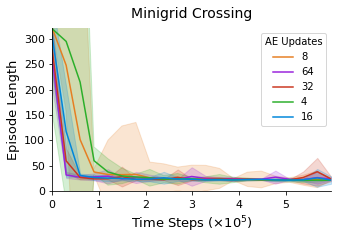

{'step': 'first', 'reward': 'mean', 'recon_loss': 'mean', 'ep_length': 'mean', 'ae_model_type': 'first', 'ae_recon_loss': 'first', 'env_name': 'first', 'mf_steps': 'mean', 'n_ae_updates': 'mean', 'rl_start_step': 'mean', 'experiment_key': 'first', 'Model Type': 'first', 'return': 'mean', 'AE Updates': 'first'}
Model Type
Discrete    15
Name: experiment_key, dtype: int64


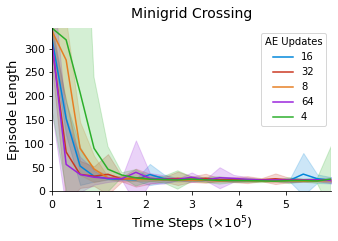

{'step': 'first', 'reward': 'mean', 'recon_loss': 'mean', 'ep_length': 'mean', 'ae_model_type': 'first', 'ae_recon_loss': 'first', 'env_name': 'first', 'mf_steps': 'mean', 'n_ae_updates': 'mean', 'rl_start_step': 'mean', 'experiment_key': 'first', 'Model Type': 'first', 'return': 'mean', 'AE Updates': 'first'}
Model Type
Discrete    15
Name: experiment_key, dtype: int64


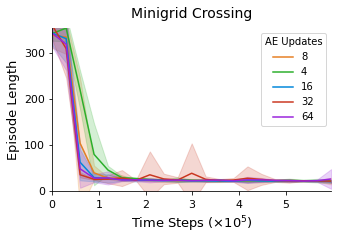

{'step': 'first', 'reward': 'mean', 'recon_loss': 'mean', 'ep_length': 'mean', 'ae_model_type': 'first', 'ae_recon_loss': 'first', 'env_name': 'first', 'mf_steps': 'mean', 'n_ae_updates': 'mean', 'rl_start_step': 'mean', 'experiment_key': 'first', 'Model Type': 'first', 'return': 'mean', 'AE Updates': 'first'}
Model Type
Discrete    15
Name: experiment_key, dtype: int64


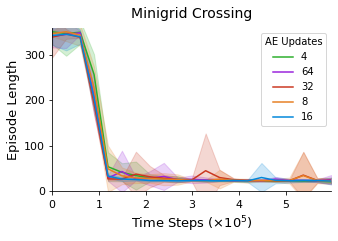

In [ ]:
group_df = df[
  (df['rl_start_step'] > 0) &
  (df['rl_start_step'] <= 100000)
]
group_df['AE Updates'] = group_df['n_ae_updates'].astype(int).astype(str)

set_matplotlib_style()

for rl_start_step, group in group_df.groupby(['rl_start_step']):
  group = bin_df(group, 20)
  env_name = group.iloc[0]['env_name']
  max_step = group['step'].max()

  print(group.groupby(['Model Type'])['experiment_key'].nunique())

  color_palette = get_color_palette(group['AE Updates'].unique())
  sns.lineplot(
    group, x='step', y='ep_length', hue='AE Updates',
    errorbar=t_distrib, palette=color_palette)

  plt.title(f'{standardize_env_name(env_name)}')
  set_fig_labels('Time Steps', 'Episode Length', xsci=True)

  plt.xlim(0, max_step)
  plt.ylim(0, np.percentile(group['ep_length'], 99))

  plt.show()